# Super Resolution for OCT images

This notebook contains code for upscale image resolution using both conventional and deep learning based methods.

Author : _Sasika Amarasinghe_

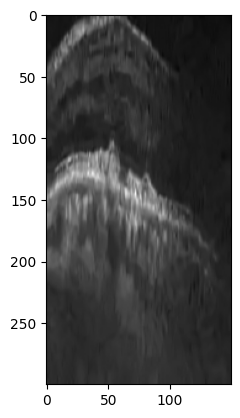

In [43]:
# load image as an opencv object

import cv2
image = cv2.imread('/content/x.png')
plt.imshow(image, cmap="gray")

___
## Conventional Methods
___

In [12]:
import cv2
import numpy as np

def get_bicubic_upsampled_array(image: np.array, width: int = 300, height: int = 300) -> np.array:
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_CUBIC)

def get_bilinear_upsampled_array(image: np.array, width: int = 300, height: int = 300) -> np.array:
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)

def get_nearest_upsampled_array(image: np.array, width: int = 300, height: int = 300) -> np.array:
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_NEAREST)

def get_lanczos_upsampled_array(image: np.array, width: int = 300, height: int = 300) -> np.array:
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_LANCZOS4)


___
## OPENCV
___

In [4]:
# download the Opencv weight file "https://drive.google.com/file/d/1Xl4ZNhhn172voFpOZ3cTQ_d5H8k_Xf9P/view?usp=sharing"

!gdown --id 1Xl4ZNhhn172voFpOZ3cTQ_d5H8k_Xf9P

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Xl4ZNhhn172voFpOZ3cTQ_d5H8k_Xf9P
To: /content/EDSR_x2.pb
100% 38.5M/38.5M [00:01<00:00, 37.9MB/s]


In [31]:
import cv2
from cv2 import dnn_superres

# Create an SR object
opencv_sr = dnn_superres.DnnSuperResImpl_create()

# Read the desired model
opencv_model_path = "/content/EDSR_x2.pb"
opencv_sr.readModel(opencv_model_path)

# Set the desired model and scale to get correct pre- and post-processing
opencv_sr.setModel("edsr", 2)

def get_opencv_dl_upscaled_array(image: np.array, width: int = 300, height: int = 300) -> np.array:
  resized_image = opencv_sr.upsample(image)
  return get_bicubic_upsampled_array(resized_image, width, height)

___
## ESR GAN
___

In [2]:
!pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git

  Cloning https://github.com/sberbank-ai/Real-ESRGAN.git to /tmp/pip-req-build-ua0zo7j2
  Running command git clone --filter=blob:none --quiet https://github.com/sberbank-ai/Real-ESRGAN.git /tmp/pip-req-build-ua0zo7j2
  Resolved https://github.com/sberbank-ai/Real-ESRGAN.git to commit 362a0316878f41dbdfbb23657b450c3353de5acf
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusol

In [40]:
# Create model
from RealESRGAN import RealESRGAN
from PIL import Image
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

esr_gan_model_scale = "2"  # ["2", "4", "8"]

esr_gan_model = RealESRGAN(device, scale=int(esr_gan_model_scale))
esr_gan_model.load_weights(f'weights/RealESRGAN_x{esr_gan_model_scale}.pth')

def get_esrgan_upscaled_array(image: np.array, width: int = 300, height: int = 300) -> np.array:
    # Convert the cv2 array to PIL image
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Use the ESRGAN model to upscale the image
    upscaled_image = esr_gan_model.predict(pil_image)

    # Convert the upscaled PIL image back to a NumPy array
    upscaled_array = np.array(upscaled_image)

    # Convert RGB to BGR
    upscaled_array = cv2.cvtColor(upscaled_array, cv2.COLOR_RGB2BGR)

    # Resize the upscaled image to the desired width and height using bicubic interpolation
    resized_image = cv2.resize(upscaled_array, (width, height), interpolation=cv2.INTER_CUBIC)

    return resized_image

device: cpu


___
## Evaluation Metrics
___

In [18]:
from skimage import exposure as ex
from skimage.filters import threshold_otsu
from skimage.morphology import convex_hull_image
import numpy as np

def get_foreground_mask(img_array, save_folder=None):

    img = bm3d_denoise_from_image_array(img_array, npsd_sigma=32)


    # Histogram equalization
    h = ex.equalize_hist(img[:,:]) * 255

    # Thresholding using Otsu's method on original image
    oi = np.zeros_like(img, dtype=np.uint16)
    oi[(img > threshold_otsu(img))] = 1

    # Thresholding using Otsu's method on histogram equalized image
    oh = np.zeros_like(img, dtype=np.uint16)
    oh[(h > threshold_otsu(h))] = 1

    # Calculate weights based on the percentage of pixels above Otsu's threshold
    nm = img.shape[0] * img.shape[1]
    w1 = np.sum(oi) / nm
    w2 = np.sum(oh) / nm

    # Combine images using weighted sum
    ots = np.zeros_like(img, dtype=np.uint16)
    new = (w1 * img) + (w2 * h)
    ots[(new > threshold_otsu(new))] = 1

    # Compute convex hull of the thresholded image
    conv_hull = convex_hull_image(ots)

    # Convert convex hull to binary (0 or 1)
    ch = np.multiply(conv_hull, 1)

    return ch

In [19]:
def get_foreground_background(image_array, foreground_mask):
    fore_img = foreground_mask*image_array
    back_img = (1-foreground_mask)*image_array
    return fore_img, back_img

In [20]:
import numpy as np

def calculate_absolute_cnr(foreground, background):
    # Convert images to float arrays for numerical operations
    foreground = foreground.astype(np.float64)
    background = background.astype(np.float64)

    # Calculate mean intensities
    mean_foreground = np.mean(foreground)
    mean_background = np.mean(background)

    # Calculate standard deviations
    std_foreground = np.std(foreground)
    std_background = np.std(background)

    # Calculate contrast-to-noise ratio (CNR)
    numerator = np.abs(mean_foreground - mean_background)
    denominator = np.sqrt((std_foreground**2 + std_background**2) / 2)
    cnr = 10*np.log10(numerator / denominator)

    return cnr

In [21]:
def calculate_msr(fore_ground_data):
    """
    Calculate Mean-to-Standard Deviation Ratio (MSR) of a dataset.

    Parameters:
    - data: NumPy array or list, input dataset

    Returns:
    - msr: float, Mean-to-Standard Deviation Ratio
    """
    # Compute mean and standard deviation of the data

    mean_val = np.mean(fore_ground_data)
    std_dev = np.std(fore_ground_data)

    # Calculate MSR (mean-to-standard deviation ratio)
    if std_dev != 0:
        msr = mean_val / std_dev
    else:
        msr = float('inf')  # Handle division by zero case

    return msr

In [ ]:
def eval_image(image_array, foreground_mask):
    # Get foreground and background images
    foreground, background = get_foreground_background(image_array, foreground_mask=foreground_mask)

    # Calculate CNR
    cnr = calculate_absolute_cnr(foreground, background)

    # Calculate MSR
    msr = calculate_msr(foreground)

    return cnr, msr

In [26]:
# prompt: function to show a numpy array using plt

import matplotlib.pyplot as plt
def show_array(image_array,fig_size=(4,4)):
  plt.figure(figsize=fig_size)
  plt.imshow(image_array, cmap='gray')
  plt.axis('on')
  plt.show()


___
## Inference
___

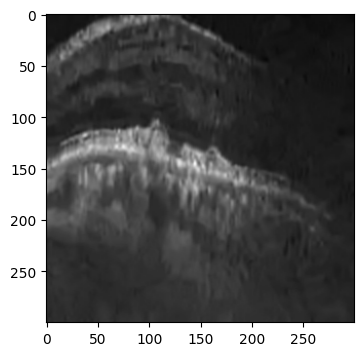

In [27]:
# bicubic image

bicubic_upsampled_array = get_bicubic_upsampled_array(image)
show_array(bicubic_upsampled_array)

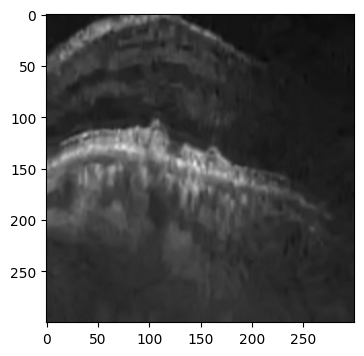

In [28]:
# bilinear image

bilinear_upsampled_array = get_bilinear_upsampled_array(image)
show_array(bilinear_upsampled_array)

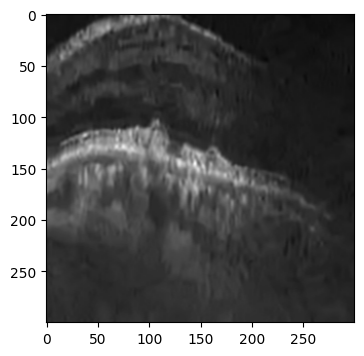

In [29]:
# Lanczos resampling

lanczos_lanczos_upsampled_array = get_lanczos_upsampled_array(image)
show_array(lanczos_lanczos_upsampled_array)

CPU times: user 1min 4s, sys: 4.58 s, total: 1min 9s
Wall time: 41.6 s


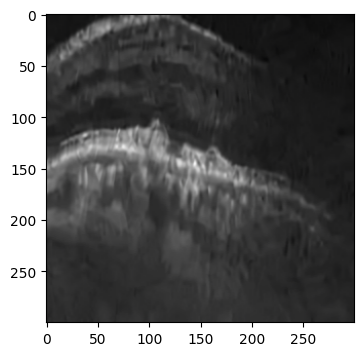

In [33]:
# Opencv model

%time opencv_upsampled_array = get_opencv_dl_upscaled_array(image)
show_array(opencv_upsampled_array)

CPU times: user 23.3 s, sys: 596 ms, total: 23.9 s
Wall time: 24.6 s


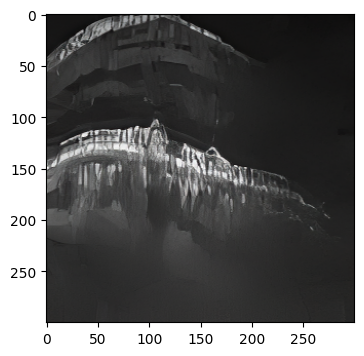

In [42]:
# ESR GAN Model image

%time esrgan_upsampled_array = get_esrgan_upscaled_array(image)
show_array(esrgan_upsampled_array)